# Google Earth Engine and Cloud Computing
**Nikos Kordalis**

**Question 1: Generate a figure showing (1) NDVI, (2), LAI, (3) Temperature, (4) Precipitation, and (5) dates of fires over your chosen location (different from the location I chose in the lab!). (25 points).**



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import ee
#The first time you use the earthengine module, you need to link your account credentials. Afterwards, your
#computer stores the authentication file
#ee.Authenticate()
ee.Initialize()
print(ee.__version__)

0.1.216


In [94]:
#Set location and dates
centroid = ee.Geometry.Point([26.253689, 103.162017])
#clipper = Centroid.buffer(3000) #This is in METERS
start_date = '2003-01-01'
end_date = '2016-01-01'

In [95]:
#Prepare helper functions
def rescale(image):
    date = image.get('system:time_start')
    return image.multiply(scale_factor).set('system:time_start', date)

def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

**(1) NDVI**

In [96]:
ROI = centroid.buffer(1000) #This is in METERS
NDVI = ee.ImageCollection('MODIS/006/MOD13A2').filter(ee.Filter.date(start_date, end_date)).select('NDVI').filterBounds(ROI)     
var = 'NDVI'
scale_factor = 0.0001
NDVI_rescale = NDVI.map(rescale)
TS = NDVI_rescale.map(createTS)
ndvi_ts, ndvi_std = TS_to_pandas(TS)
#ndvi_ts.plot(figsize=(15,10))
#grid()

**(2) LAI**

In [97]:
ROI = centroid.buffer(1000) #This is in METERS
LAI = ee.ImageCollection("MODIS/006/MCD15A3H").filter(ee.Filter.date(start_date, end_date)).select('Lai').filterBounds(ROI) 
var = 'Lai' # MOD13A2 this is having the ndvi
scale_factor = 0.1 # can be found on google engine catalog for the data
LAI_rescale = LAI.map(rescale)
TS = LAI_rescale.map(createTS) # turn into time series
lai_ts, lai_std = TS_to_pandas(TS)
#lai_ts.plot(figsize=(15,5), color = '#2dad86', title = 'Leaf Area Index')

**(3) Temperature**

In [98]:
ROI = centroid.buffer(1000) #This is in METERS
LST = ee.ImageCollection("MODIS/006/MOD11A2") .filter(ee.Filter.date(start_date, end_date)).select('LST_Day_1km').filterBounds(ROI)     
# recommend MOD11A2 for LST,
var = 'LST_Day_1km' # MOD13A2 this is having the ndvi
scale_factor = 0.02 # can be found on google engine catalog for the data
LST_rescale = LST.map(rescale)
TS = LST_rescale.map(createTS) # turn into time series
lst_ts, lst_std = TS_to_pandas(TS)
lst_ts_celsius = lst_ts-273.15
#lst_ts_celsius.plot(figsize=(15,5), color = '#2dad86', title = 'Land Surface Temperature')

**(4) Precipitation**

In [119]:
ROI = centroid.buffer(30000) #This is in METERS, for the precipitation we set s a bigger buffer because the pixel
# size of the TRMM dataset is 25000m on each side
P = ee.ImageCollection("TRMM/3B43V7").filter(ee.Filter.date(start_date, end_date)).select('precipitation').filterBounds(ROI)
var = 'precipitation' 
scale_factor = 1 
P_rescale = P.map(rescale)
TS = P_rescale.map(createTS) 
p_ts, p_std = TS_to_pandas(TS)
#p_ts.plot(figsize=(15,5), color = 'blue', title = 'Precipitation')

**(5) Dates of fires**

In [100]:
#Option 1: Load the whole file at once
import geopandas as gpd
gid = '/NAS/GFED4/GFED4_2003-2016.gpkg'
#df = gpd.read_file(gid)
#print(df.head())

In [ ]:
#Option 2: Load each year you need one at a time
from shapely.geometry import Point
import geopandas as gpd

def fire_dates_GFED(pt, yrmin, yrmax):
    geo_coord = Point(pt)
    out = []
    for yr in range(yrmin, yrmax):
        gdf = gpd.read_file('/NAS/GFED4/' + str(yr) + '/Global_fire_atlas_V1_perimeter_' + str(yr) + '.shp')
        int_pts = gdf[gdf.intersects(geo_coord)]
        out.append(int_pts)
    return gpd.GeoDataFrame(pd.concat(out, ignore_index=True))

fire_df = fire_dates_GFED([23.5541, 38.1688], 2003, 2016)
#fire_df = fire_dates_GFED([132.378, -17.391], 2008, 2011)
print(fire_df)

In [102]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

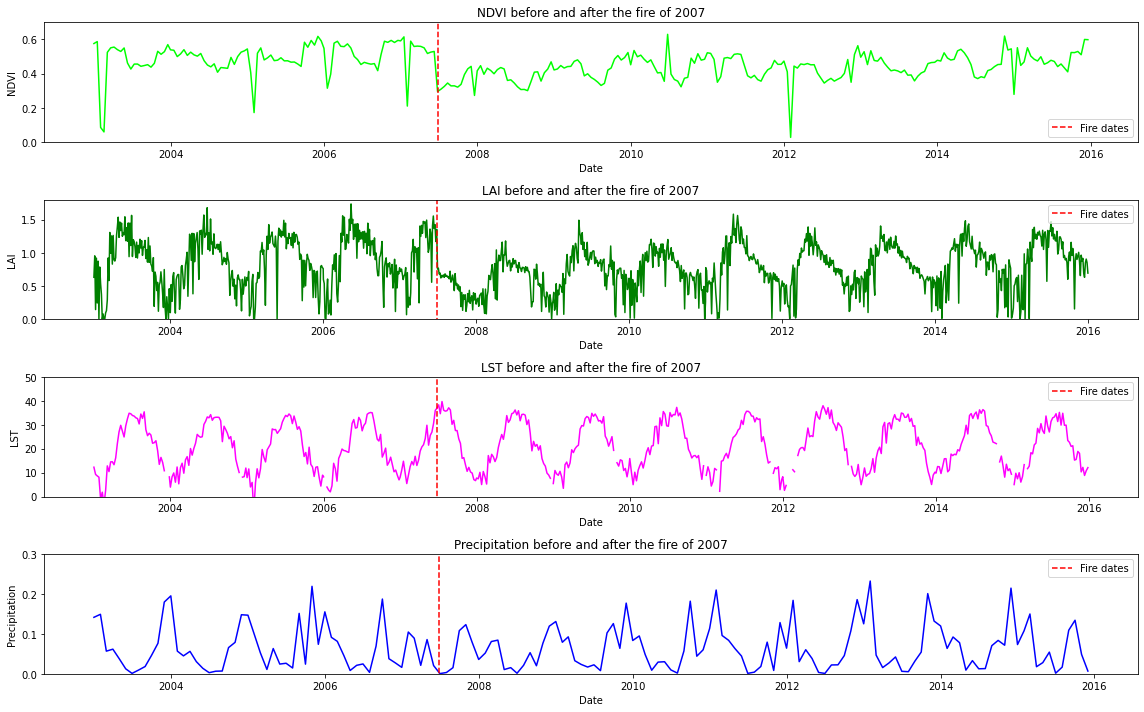

In [103]:
fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(411)
ax1.plot(ndvi_ts.index, ndvi_ts.values,color = 'lime')
for i, v in enumerate(fire_df.start_date.values):
    stamp = pd.Timestamp(v)
    ax1.plot((stamp, stamp),(-10,10), 'r--', label='Fire dates')
ax1.set_ylim(0, 0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI')
ax1.legend()
ax1.title.set_text('NDVI before and after the fire of 2007')

ax2 = fig.add_subplot(412)
ax2.plot(lai_ts.index, lai_ts.values,color = 'green')
for i, v in enumerate(fire_df.start_date.values):
    stamp = pd.Timestamp(v)
    ax2.plot((stamp, stamp),  (-10,10) ,'r--', label='Fire dates')
ax2.set_ylim(0, 1.8)
ax2.set_xlabel('Date')
ax2.set_ylabel('LAI')
ax2.legend()
ax2.title.set_text('LAI before and after the fire of 2007')

ax3 = fig.add_subplot(413)
ax3.plot(lst_ts_celsius.index, lst_ts_celsius.values,color = 'magenta')
for i, v in enumerate(fire_df.start_date.values):
    stamp = pd.Timestamp(v)
    ax3.plot((stamp, stamp),  (-10,50) ,'r--', label='Fire dates')
ax3.set_ylim(0, 50)
ax3.set_xlabel('Date')
ax3.set_ylabel('LST')
ax3.legend()
ax3.title.set_text('LST before and after the fire of 2007')

ax4 = fig.add_subplot(414)
ax4.plot(p_ts.index, p_ts.values,color = 'blue')
for i, v in enumerate(fire_df.start_date.values):
    stamp = pd.Timestamp(v)
    ax4.plot((stamp, stamp),  (-10,10) ,'r--', label='Fire dates')
ax4.set_ylim(0, 0.3)
ax4.set_xlabel('Date')
ax4.set_ylabel('Precipitation')
ax4.legend()
ax4.title.set_text('Precipitation before and after the fire of 2007')

fig.tight_layout()

**Question 2: Investigate the links between vegetation, fire, precipitation, and temperature over your study point. Are there any strong patterns? Do you notice that there are more fires in dry years? Wet years? You will likely want to normalize or de-season your time series data, so that you can see the impacts of fires more clearly. (25 points).**

In [1]:
from Lab04_FX import fix_time_SPOT,  chen_proc

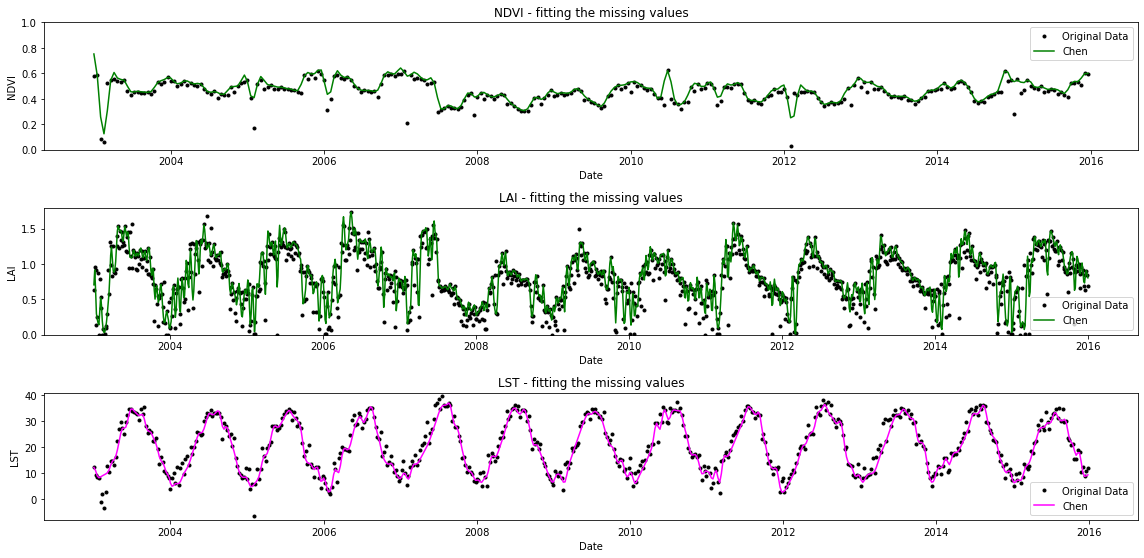

In [142]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(411)
ts1 = ndvi_ts.interpolate()
ax1.plot(ts1.index, ts1.values, 'k.', label='Original Data')
ax1.plot(ts1.index, chen_proc(ts1)[0], 'g', label='Chen')
ax1.legend(loc = 'lower right')
ax1.set_ylim(0, 1)
ax1.set_title('NDVI - fitting the missing values')
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI')
ax1.legend()


ax2 = fig.add_subplot(412)
ts2 = lai_ts.interpolate()
ax2.plot(ts2.index, ts2.values, 'k.', label='Original Data')
ax2.plot(ts2.index, chen_proc(ts2)[0], 'g', label='Chen')
ax2.legend(loc = 'lower right')
ax2.set_ylim(0, 1.8)
ax2.set_title('LAI - fitting the missing values')
ax2.set_xlabel('Date')
ax2.set_ylabel('LAI')
ax2.legend()


ax3 = fig.add_subplot(413)
ts3 = lst_ts_celsius.interpolate()
ax3.plot(ts3.index, ts3.values, 'k.', label='Original Data')
ax3.plot(ts3.index, chen_proc(ts3)[0], 'magenta', label='Chen')
ax3.legend(loc = 'lower right')
ax3.set_ylim(-8, 41)
ax3.set_title('LST - fitting the missing values')
ax3.set_xlabel('Date')
ax3.set_ylabel('LST')
ax3.legend()


fig.tight_layout()
import datetime
ax.set_xlim(datetime.datetime(2002,12,1),datetime.datetime(2017,1,1))
plt.show()

The  **Chen method**  fits well in our data.

In [143]:
ndvi_chen=chen_proc(ts1)[0]
lai_chen = chen_proc(ts2)[0]
lst_chen = chen_proc(ts3)[0]

In [147]:
def norm(x):
    return (x - np.nanmean(x)) / np.nanstd(x)

ndvi_norm = pd.Series(np.apply_along_axis(norm,  axis=0,  arr=ndvi_chen), index = ts1.index)
lai_norm  = pd.Series(np.apply_along_axis(norm,  axis=0,  arr=lai_chen),  index = ts2.index)
lst_norm  = pd.Series(np.apply_along_axis(norm,  axis=0,  arr=lst_chen),   index = ts3.index)
pr_norm   = pd.Series(np.apply_along_axis(norm,  axis=0,  arr=p_ts),   index = p_ts.index)

In [261]:
 def plot(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-4,3),'r--', label='Fire dates')
      
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized '+index)
        ax.grid()

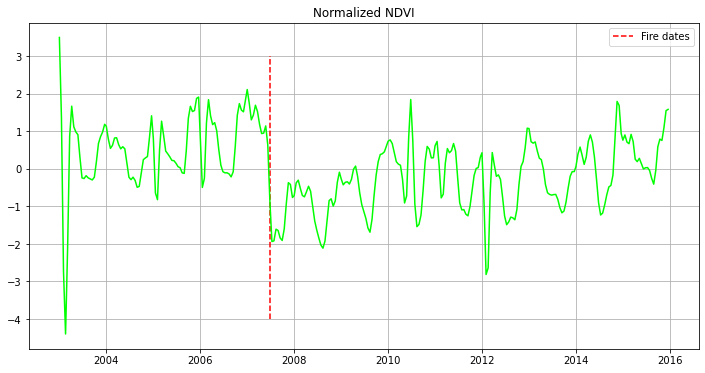

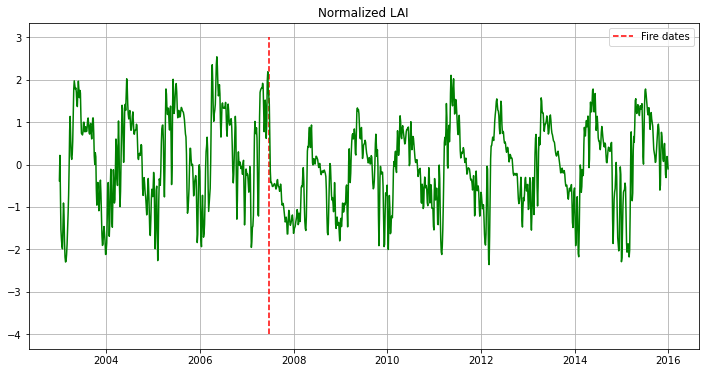

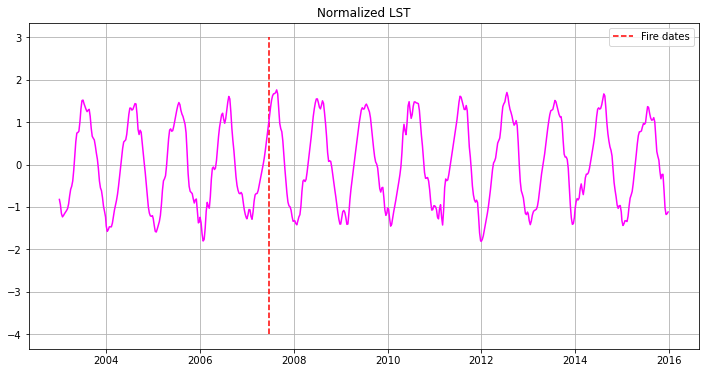

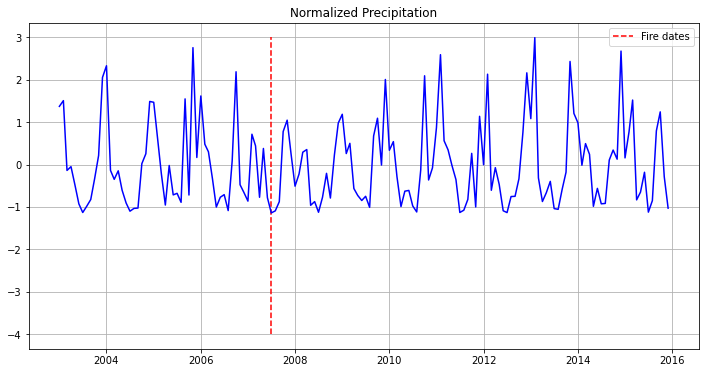

In [262]:
plot(ndvi_norm, 'lime','NDVI')
plot(lai_norm, 'green','LAI')
plot(lst_norm, 'magenta','LST')
plot(pr_norm,'blue', 'Precipitation')

In [ ]:
import statsmodels.api as sm   
decomp1 = sm.tsa.seasonal_decompose(ndvi_norm, model='additive', freq=36) 
decomp2 = sm.tsa.seasonal_decompose(lai_norm, model='additive', freq=36) 
decomp3 = sm.tsa.seasonal_decompose(lst_norm, model='additive', freq=36) 
decomp4 = sm.tsa.seasonal_decompose(pr_norm, model='additive', freq=36) 

In [ ]:
from Lab04_FX import fix_time_SPOT
date = list(map(lambda x: fix_time_SPOT(x), date))

ser = pd.Series(data[150, 150, :], index=date)
vals_norm = (ser.values - np.nanmean(ser.values)) / np.nanstd(ser.values)
ser_norm = pd.Series(vals_norm, index=date)


ser2 = pd.Series(data[200, 200, :], index=date)

**1) Method seosonal**

In [263]:
def plot2(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-0.21,0.2),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized and Seosonal Decomposed '+index)
        ax.grid()
        
def plot2a(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-1.5,1),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized and Seosonal Decomposed '+index)
        ax.grid()
        
def plot2b(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-0.5,0.5),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized and Seosonal Decomposed '+index)
        ax.grid()

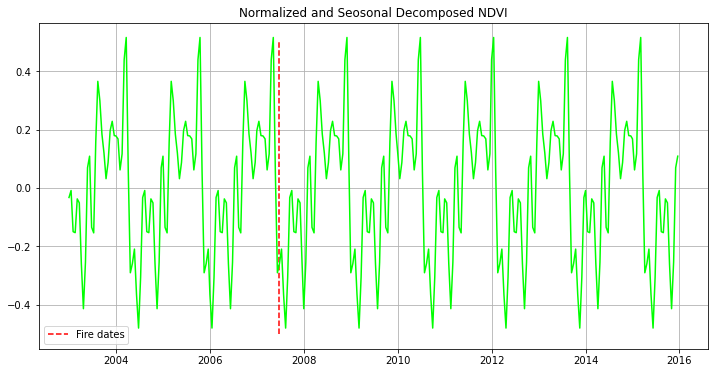

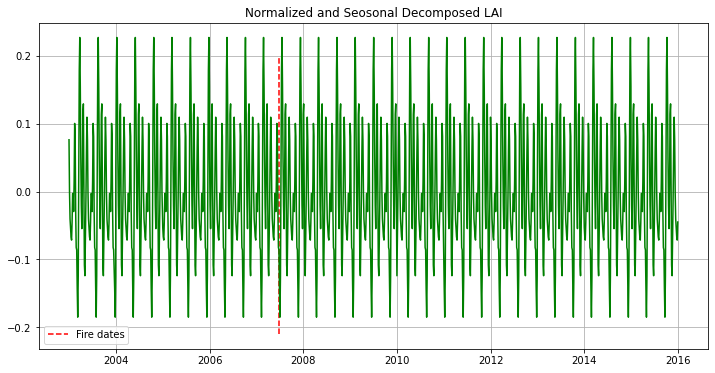

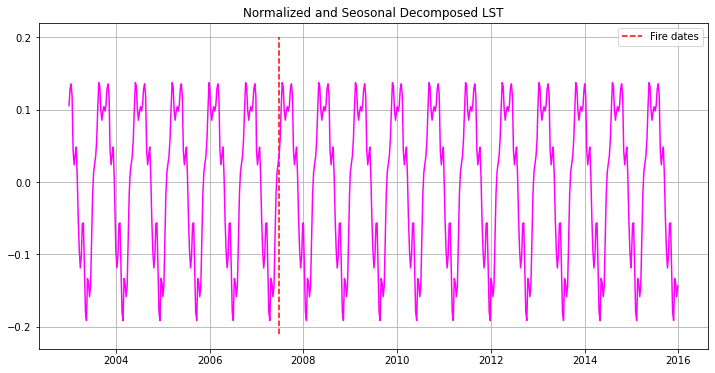

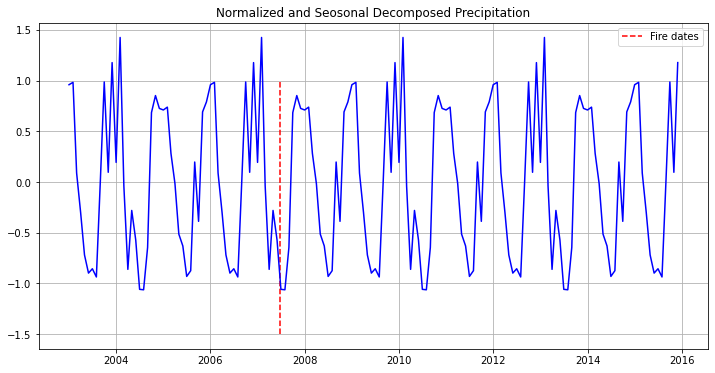

In [264]:
plot2b(decomp1.seasonal, 'lime','NDVI')
plot2(decomp2.seasonal, 'green','LAI')
plot2(decomp3.seasonal, 'magenta','LST')
plot2a(decomp4.seasonal,'blue', 'Precipitation')

**2) Method trend**

In [265]:
def plot3(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-1.5,1.5),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.title.set_text('Normalized and Trend Decomposed '+index)
        ax.legend()
        ax.grid()

def plot3a(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-0.2,0.1),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized and Trend Decomposed '+index)
        ax.grid()

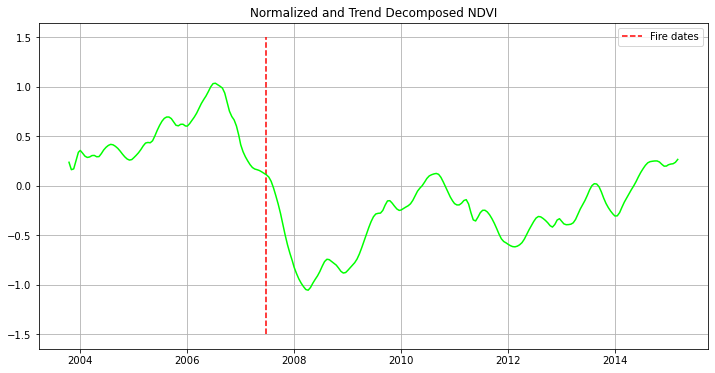

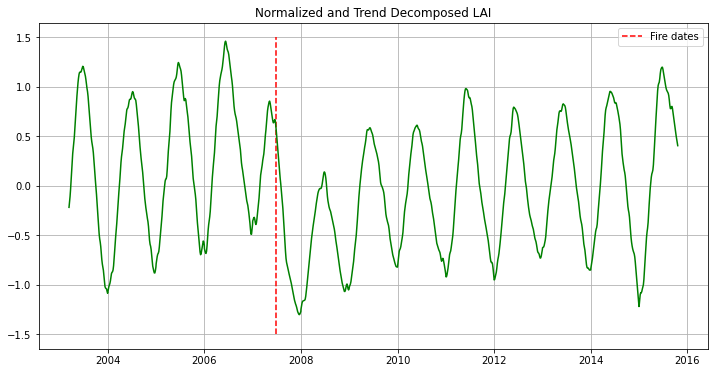

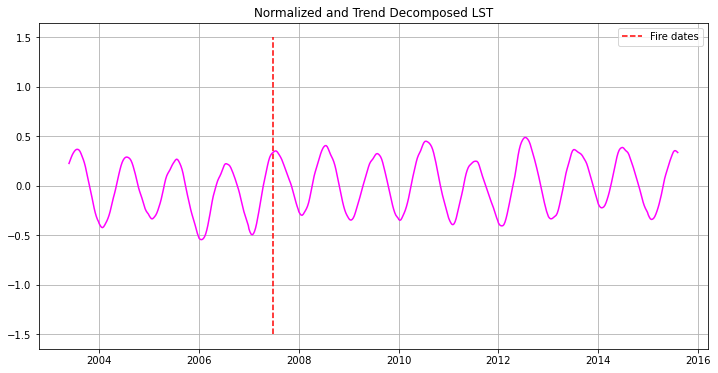

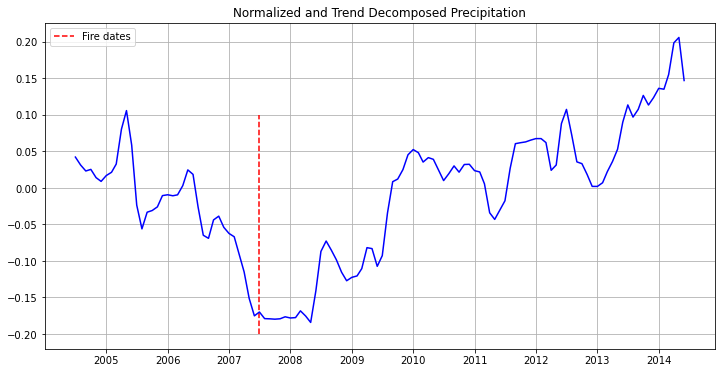

In [266]:
plot3(decomp1.trend, 'lime','NDVI')
plot3(decomp2.trend, 'green','LAI')
plot3(decomp3.trend, 'magenta','LST')
plot3a(decomp4.trend,'blue', 'Precipitation')

**3) Method resid**

In [269]:
def plot4(data1,c, index): 
        plt.figure(figsize=(12,6))
        ax = plt.gca()
        for i, v in enumerate(fire_df.start_date.values):
            stamp = pd.Timestamp(v)
            ax.plot((stamp, stamp) ,(-2,2),'r--', label='Fire dates')
        ax.plot(data1,c)
        ax.legend()
        ax.title.set_text('Normalized and Resid Decomposed '+index)
        ax.grid()

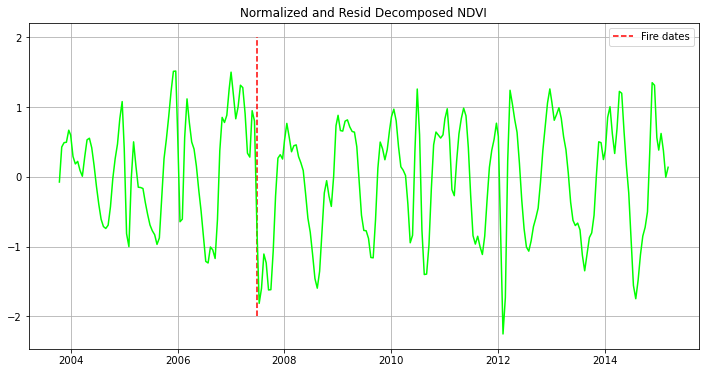

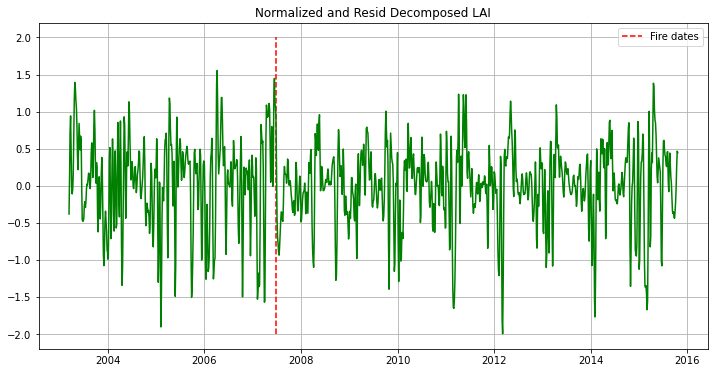

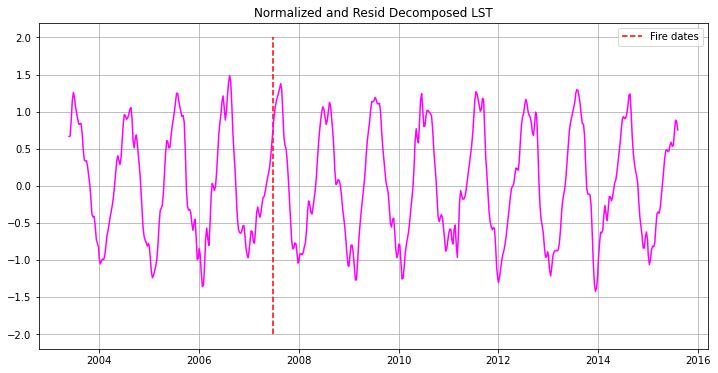

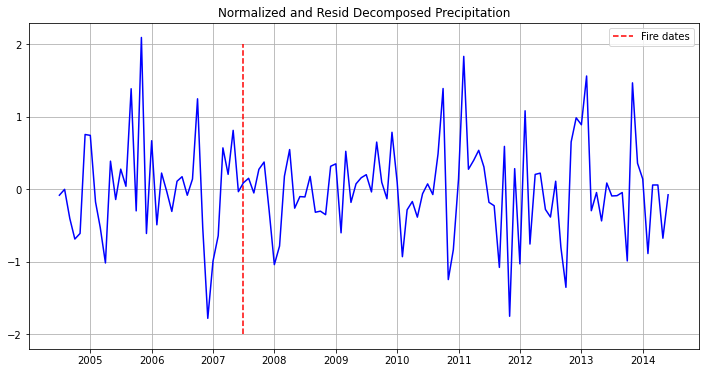

In [270]:
plot4(decomp1.resid, 'lime','NDVI')
plot4(decomp2.resid, 'green','LAI')
plot4(decomp3.resid, 'magenta','LST')
plot4(decomp4.resid, 'blue', 'Precipitation')

Only one large fire was recorded in the period 2003-2016. The fire broke out in June 2007. After the normalization the decomposition of the initial data (NDVI, LAI, LST, precipetation) it was it was easier and clearer to draw some conclusions. The method "trend" better showed the effect of fire on the ecosystem. According to the figures (trend method) both NDVI and LAI experience a downward trend for the following years. The LST maximums and the LST minimums reach higher values the following years. Moreover, before the fire breaks out the NDVI  has already experinced  downward trend that continued and after the event of the fire. The downward trend of the NDVI is correlated with the trend of precipitation (before the fire) that indicates a long period of dry.